# State of Top 20 Languages: Readership via Unique Devices

This notebook analyzes project coverage for the top 20 most spoken languages of 2023.

In this notebook,
* **projects** refer to [Wikimedia content projects](https://meta.wikimedia.org/wiki/Wikimedia_projects) that have linguistic editions: Wikibooks, Wikinews, Wikipedia, Wikiquote, Wikisource, Wikiversity, Wikivoyage, and Wiktionary;
* **hosted projects** refer to projects (as defined above) that have their own domain and are hosted by the Wikimedia Foundation; and
* Readership is examined by looking at the number of [**unique devices**](https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Unique_Devices) accessing 
     * **desktop** versions of a project (e.g., https://es.wikipedia.org/)
     * **mobile versions** of a project (e.g., https://es.m.wikipedia.org/)

For the year 2023, the "top 20" were determined via Ethnologue's 2023 "Ethnologue 200" list, from which the top 20 were listed online at https://www.ethnologue.com/insights/ethnologue200/ (archived at http://web.archive.org/web/20230309070105/https://www.ethnologue.com/insights/ethnologue200/)

Citation: Eberhard, David M., Gary F. Simons, and Charles D. Fennig (eds.). 2023. Ethnologue: Languages of the World. Twenty-sixth edition. Dallas, Texas: SIL International. Online version: http://www.ethnologue.com.

## Packages and Functions

In [ ]:
# Packages
library(tidyverse)
library(janitor)
library(kableExtra)# for html tables
library(IRdisplay) # for html tables
library(DT) # for html tables
library(here)
library(ggrepel)

In [2]:
#install.packages("remotes", repos = c(CRAN = "https://cran.rstudio.com/"))
#remotes::install_github("wikimedia/wmfdata-r")
library(wmfdata)
library(glue)

In [ ]:
#prep to be able to run spark queries using reticulate package
#per https://wikitech.wikimedia.org/wiki/Data_Engineering/Systems/Conda#wmfdata-python_through_reticulate
library(jsonlite)
library(reticulate)
conda_env_data <- paste(
    system2(
        "conda",
        args = c("info", "-a", "--json"),
        stdout = TRUE),
    collapse = '') |>
    fromJSON()
use_condaenv(conda_env_data[['active_prefix']])
wmfdata <- import('wmfdata')

In [4]:
## ggplot theme: state of languages (sol) theme ---------

theme_sol <- function(){ 
      
  theme(legend.position="none", 
        axis.title=element_blank(), 
        axis.text.y=element_text(size=18),
        axis.text.x=element_blank(),
        plot.title=element_text(size=24),
        plot.subtitle=element_text(size=18),
        plot.caption=element_text(size=12)
       )  

}

In [5]:
# increase column and row maxes
options(repr.matrix.max.cols=12, repr.matrix.max.rows=1100)

## Read in data

**First, state of languages data**

In [ ]:
df_import <- read_tsv("outputs/state_of_languages_with_counts_and_notes.tsv")

**Second, query unique devices data**

In [6]:
## Spark query: avg monthly unique device estimates, per wiki domain, in 2023

#query
uniques <- wmfdata$spark$run("
WITH
    base_df AS(
                SELECT 
                    SUM(uniques_estimate) as monthly_uniques,
                    year,
                    month,
                    domain
                FROM wmf.unique_devices_per_domain_monthly
                WHERE year=2023 
                GROUP BY 
                    year, 
                    month,
                    domain
                )
SELECT
     ROUND(AVG(monthly_uniques),-3) as avg_monthly_unique_devices_estimate,
     year,
     domain
FROM base_df
GROUP BY 
    year, 
    domain
")

#check
head(uniques %>% arrange(desc(avg_monthly_unique_devices_estimate)))

avg_monthly_unique_devices_estimate year domain            
1 649367000                           2023 en.m.wikipedia.org
2 231298000                           2023 en.wikipedia.org  
3 102976000                           2023 es.m.wikipedia.org
4  75617000                           2023 ru.m.wikipedia.org
5  74778000                           2023 ja.m.wikipedia.org
6  68572000                           2023 fr.m.wikipedia.org

**Finally, bring in bridge for project name and language code**

In [ ]:
langs <- read_tsv("../03_wrangled_data/project_languages.tsv") %>%
   select(language_name, language_code)

### Prep "df_top_20"
Dataframe for examining stats about the *top 20* languages ranked by speaker numbers.

**Source**: For the year 2023, the "top 20" were determined via Ethnologue's 2023 "Ethnologue 200" list, from which the top 20 were listed online at https://www.ethnologue.com/insights/ethnologue200/ (archived at http://web.archive.org/web/20230309070105/https://www.ethnologue.com/insights/ethnologue200/)

**Citation**: Eberhard, David M., Gary F. Simons, and Charles D. Fennig (eds.). 2023. Ethnologue: Languages of the World. Twenty-sixth edition. Dallas, Texas: SIL International. Online version: http://www.ethnologue.com.


In [11]:
df <- df_import
df$Wikibooks[is.na(df$Wikibooks)] <- "(none)"
df$Wikinews[is.na(df$Wikinews)] <- "(none)"
df$Wikipedia[is.na(df$Wikipedia)] <- "(none)"
df$Wikiquote[is.na(df$Wikiquote)] <- "(none)"
df$Wikisource[is.na(df$Wikisource)] <- "(none)"
df$Wiktionary[is.na(df$Wiktionary)] <- "(none)"
df$Wikiversity[is.na(df$Wikiversity)] <- "(none)"
df$Wikivoyage[is.na(df$Wikivoyage)] <- "(none)"

In [12]:
df_top_20 <- df %>% filter(language_name=="English" | #1
                  language_name=="Chinese" | #2
                  language_name=="Hindi" | #3
                  language_name=="Spanish" | #4
                  language_name=="French" | #5
                  language_name=="Arabic" | #6
                  grepl("Bangla|Bengali", language_name) | #7
                  language_name=="Portuguese" | #8
                  language_name=="Russian" | #9
                  language_name=="Urdu" | #10
                  language_name=="Indonesian" | #11
                  language_name=="German" | #12
                  language_name=="Japanese" | #13
                  grepl("Nigerian Pidgin", language_name) | #14
                  language_name=="Egyptian Arabic" | #15
                  language_name=="Marathi" | #16
                  language_name=="Telugu" | #17
                  language_name=="Turkish" | #18
                  language_name=="Tamil" | #19
                  grepl("Yue|Cantonese", language_name) ) #20
nrow(df_top_20)

[1] 20

In [13]:
# Wikipedia: add the language codes and make a wiki_db+wp column, for matching with product data
df_top_20 <- df_top_20 %>%
   left_join(., langs, by="language_name") %>%
   distinct(.)
df_top_20$wiki_db_wp = paste(df_top_20$language_code, "wiki", sep="")

        # hand correct for Cantonese/Yue
        df_top_20$wiki_db_wp[df_top_20$language_name=="Cantonese"] <- "zh_yuewiki"

# Wiktionary: make a wiki_db_wt column, for matching with product data
df_top_20$wiki_db_wt = paste(df_top_20$language_code, "wiktionary", sep="")

# Wikisource: make a wiki_db_ws column, for matching with product data
df_top_20$wiki_db_ws = paste(df_top_20$language_code, "wikisource", sep="")


In [14]:
# add rounded speaker numbers
df_top_20$speakers <- NA
df_top_20$speakers[df_top_20$language_name=="English"]           <- 1500000000 # 1
df_top_20$speakers[df_top_20$language_name=="Chinese"]           <- 1100000000 # 2, Ethnologue called "Mandarin Chinese"
df_top_20$speakers[df_top_20$language_name=="Hindi"]             <-  609500000 # 3
df_top_20$speakers[df_top_20$language_name=="Spanish"]           <-  559100000 # 4
df_top_20$speakers[df_top_20$language_name=="French"]            <-  309800000 # 5
df_top_20$speakers[df_top_20$language_name=="Arabic"]            <-  274000000 # 6, Ethnologue called "Standard Arabic"
df_top_20$speakers[df_top_20$language_name=="Bangla"]            <-  272800000 # 7
df_top_20$speakers[df_top_20$language_name=="Portuguese"]        <-  263600000 # 8
df_top_20$speakers[df_top_20$language_name=="Russian"]           <-  255000000 # 9
df_top_20$speakers[df_top_20$language_name=="Urdu"]              <-  231700000 # 10
df_top_20$speakers[df_top_20$language_name=="Indonesian"]        <-  199100000 # 11
df_top_20$speakers[df_top_20$language_name=="German"]            <-  133200000 # 12, Ethnologue called "Standard German"
df_top_20$speakers[df_top_20$language_name=="Japanese"]          <-  123400000 # 13
df_top_20$speakers[df_top_20$language_name=="Nigerian Pidgin"]   <-  120700000 # 14
df_top_20$speakers[df_top_20$language_name=="Egyptian Arabic"]   <-  102400000 # 15, Ethnologue called "Egyptian Spoken Arabic"
df_top_20$speakers[df_top_20$language_name=="Marathi"]           <-   99200000 # 16
df_top_20$speakers[df_top_20$language_name=="Telugu"]            <-   96000000 # 17
df_top_20$speakers[df_top_20$language_name=="Turkish"]           <-   90000000 # 18
df_top_20$speakers[df_top_20$language_name=="Tamil"]             <-   86600000 # 19
df_top_20$speakers[df_top_20$language_name=="Cantonese"]         <-   86600000 # 20 Ethnologue called "Yue Chinese"

# Speaker numbers source: For the year 2023, speaker numbers for the top 20 were listed online at https://www.ethnologue.com/insights/ethnologue200/ 
# (archived at http://web.archive.org/web/20230309070105/https://www.ethnologue.com/insights/ethnologue200/)

# Citation: Eberhard, David M., Gary F. Simons, and Charles D. Fennig (eds.). 2023. Ethnologue: Languages of the World. Twenty-sixth edition. 
# Dallas, Texas: SIL International. Online version: http://www.ethnologue.com.

In [15]:
# Wrangle the unique devices data

#distinguish mobile/desktop
uniques$domain_type <- NA
uniques$domain_type[grepl("\\.m.", uniques$domain)] <- "mobile"
uniques$domain_type[!grepl("\\.m.", uniques$domain)] <- "desktop"

#distinguish project type
uniques$temp1 <- gsub("\\..*","",uniques$domain)
uniques$temp2 <- NA
uniques$temp2[grepl("wikibooks", uniques$domain)] <- "wikibooks"
uniques$temp2[grepl("wikinews", uniques$domain)] <- "wikinews"
uniques$temp2[grepl("wikipedia", uniques$domain)] <- "wiki"
uniques$temp2[grepl("wikiquote", uniques$domain)] <- "wikiquote"
uniques$temp2[grepl("wikisource", uniques$domain)] <- "wikisource"
uniques$temp2[grepl("wiktionary", uniques$domain)] <- "wiktionary"
uniques$temp2[grepl("wikiversity", uniques$domain)] <- "wikiversity"
uniques$temp2[grepl("wikivoyage", uniques$domain)] <- "wikivoyage"

#remove filter for content projects and add wiki_db column
uniques <- uniques %>% 
  filter(!is.na(temp2)) %>% # remove non content projects
  mutate(wiki_db = paste0(temp1, temp2)) %>% # add wiki_db column for bridge
  select(wiki_db, domain, domain_type, year, avg_monthly_unique_devices_estimate)

        # hand correct for Cantonese/Yue
        uniques$wiki_db[uniques$wiki_db=="zh-yuewiki"] <- "zh_yuewiki"

#spread mobile and desktop
uniques <- uniques %>%
  select(-domain) %>% # remove domain URLS 
  spread(key="domain_type", value="avg_monthly_unique_devices_estimate") %>% #spread
  dplyr::rename(avg_monthly_uniques_2023_desktop = desktop) %>%
  dplyr::rename(avg_monthly_uniques_2023_mobile = mobile)

In [16]:
# join unique devices data with top_20_df
# (FOR NOW, WIKIPEDIAS ONLY)

df_top_20 <- df_top_20 %>%
   left_join(., uniques, by=c("wiki_db_wp"="wiki_db")) %>%
   dplyr::rename(wp_uniques_desktop = avg_monthly_uniques_2023_desktop) %>%
   dplyr::rename(wp_uniques_mobile = avg_monthly_uniques_2023_mobile) 

head(df_top_20)

language_name   Wikibooks Wikinews Wikipedia Wikiquote Wikisource ⋯
1 Arabic          hosted    hosted   hosted    hosted    hosted     ⋯
2 Bangla          hosted    test     hosted    hosted    hosted     ⋯
3 Cantonese       test      test     hosted    test      test       ⋯
4 Chinese         hosted    hosted   hosted    hosted    hosted     ⋯
5 Egyptian Arabic test      -        hosted    test      -          ⋯
6 English         hosted    hosted   hosted    hosted    hosted     ⋯
  wiki_db_wt    wiki_db_ws    speakers  year wp_uniques_desktop
1 arwiktionary  arwikisource  2.740e+08 2023   5426000         
2 bnwiktionary  bnwikisource  2.728e+08 2023    474000         
3 yuewiktionary yuewikisource 8.660e+07 2023    579000         
4 zhwiktionary  zhwikisource  1.100e+09 2023  16491000         
5 arzwiktionary arzwikisource 1.024e+08 2023    433000         
6 enwiktionary  enwikisource  1.500e+09 2023 231298000         
  wp_uniques_mobile
1  41775000        
2   5307000        
3   1204000        
4  32932000        
5   2626000        
6 649367000

## **Top 20 Languages: Wikipedia desktop readers**

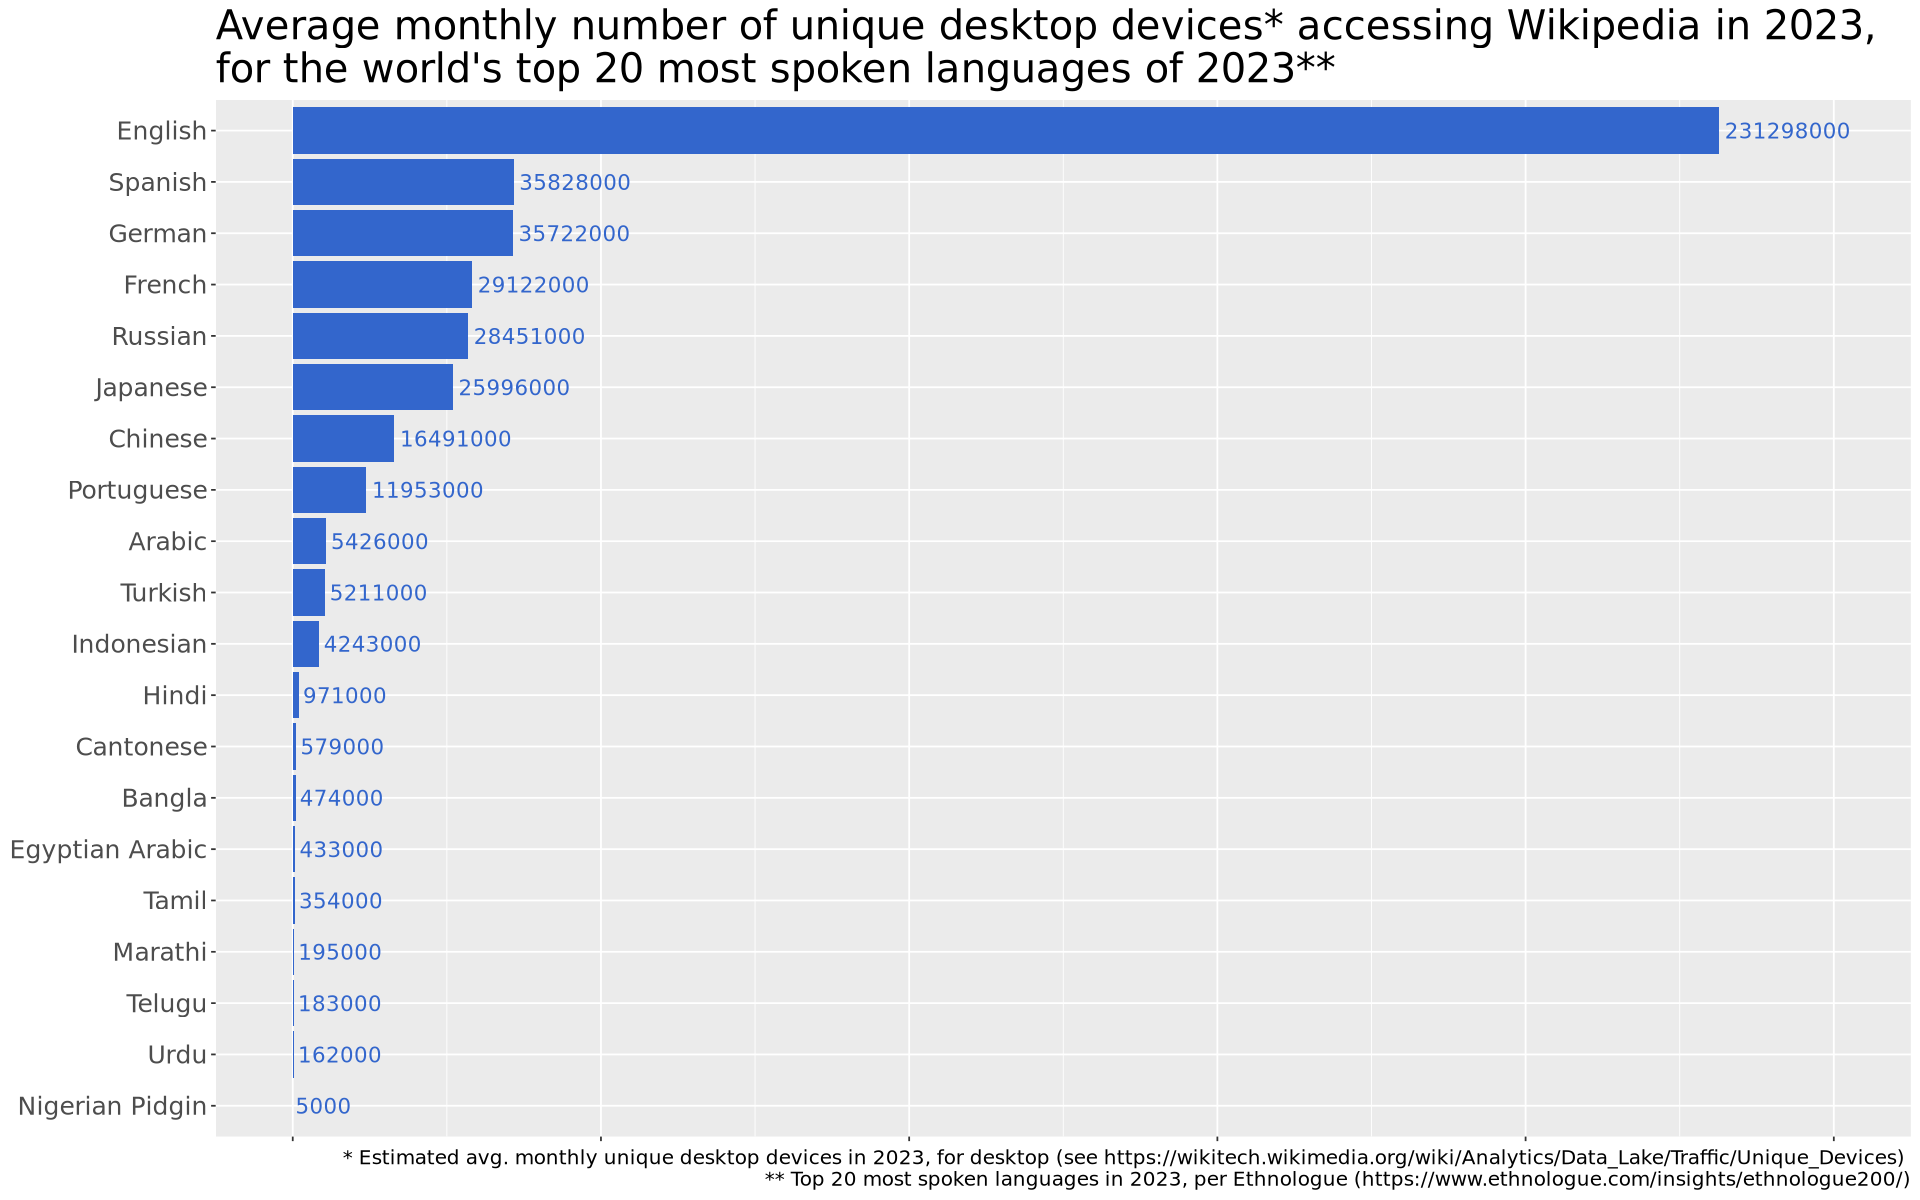

In [58]:
# Plot: Wikipedia desktop devices per language
options(repr.plot.width=16, repr.plot.height=10)
df_top_20 %>%
  ggplot(aes(x=reorder(language_name, wp_uniques_desktop), y=wp_uniques_desktop)) +
  geom_bar(position = position_dodge(), stat="identity", fill = "#3366CC") +
  geom_text(aes(label = round(wp_uniques_desktop,0)), hjust = -0.05, color="#3366CC", size=4.5) +
  theme_sol() +
  coord_flip() + 
  labs(title = "Average monthly number of unique desktop devices* accessing Wikipedia in 2023, \nfor the world's top 20 most spoken languages of 2023**",
    #   subtitle = "",
       caption = "* Estimated avg. monthly unique desktop devices in 2023, for desktop (see https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Unique_Devices) \n** Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  theme(axis.text.y = element_text(size=15), plot.subtitle = element_text(color="grey")) +
  ylim(c(0,250000000))

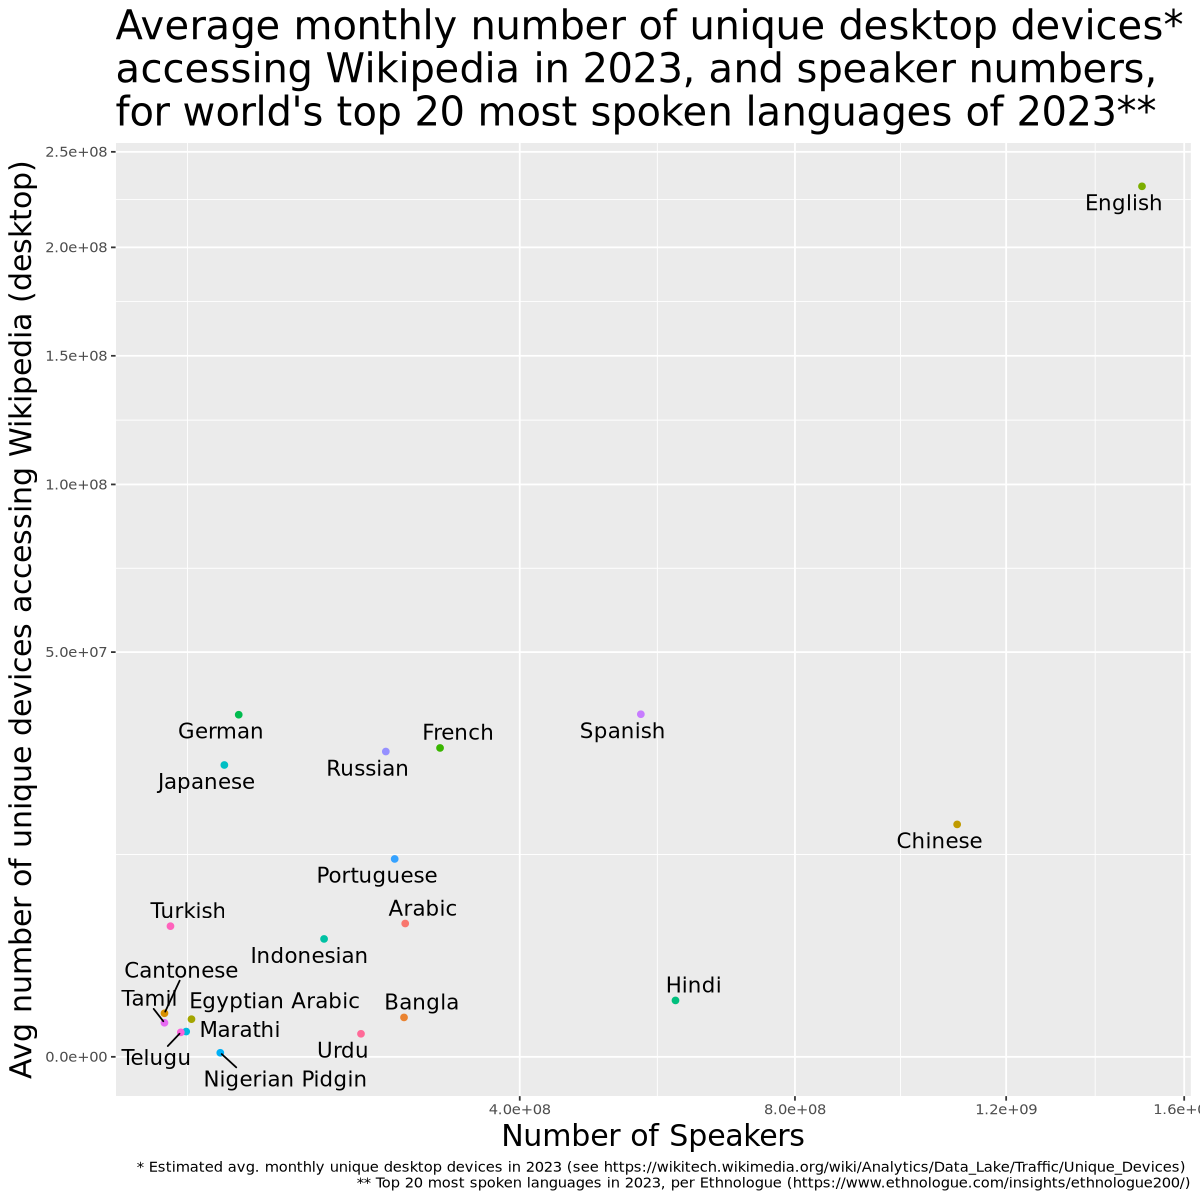

In [57]:
# Plot: Wikipiedia desktop unique devices x speaker numbers, per language
# Axis transformation: squareroot
options(repr.plot.width=10, repr.plot.height=10)
df_top_20 %>%
  ggplot(aes(x=speakers, y=wp_uniques_desktop, label=language_name)) +
  geom_point(aes(color=factor(language_name)) ) +
  geom_text_repel(size=4.5, max.overlaps=20) +
  theme(legend.position="none", axis.title=element_text(size=18), plot.title=element_text(size=24),
        plot.subtitle = element_text(color="grey", size=18)) +
  labs(title = "Average monthly number of unique desktop devices* \naccessing Wikipedia in 2023, and speaker numbers, \nfor world's top 20 most spoken languages of 2023**",
   #    subtitle = "",
       caption = "* Estimated avg. monthly unique desktop devices in 2023 (see https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Unique_Devices) \n** Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  xlab("Number of Speakers") + ylab("Avg number of unique devices accessing Wikipedia (desktop)") +
  scale_x_continuous(trans='sqrt') +
  scale_y_continuous(trans='sqrt')

## **Top 20 Languages: Wikipedia mobile readers**

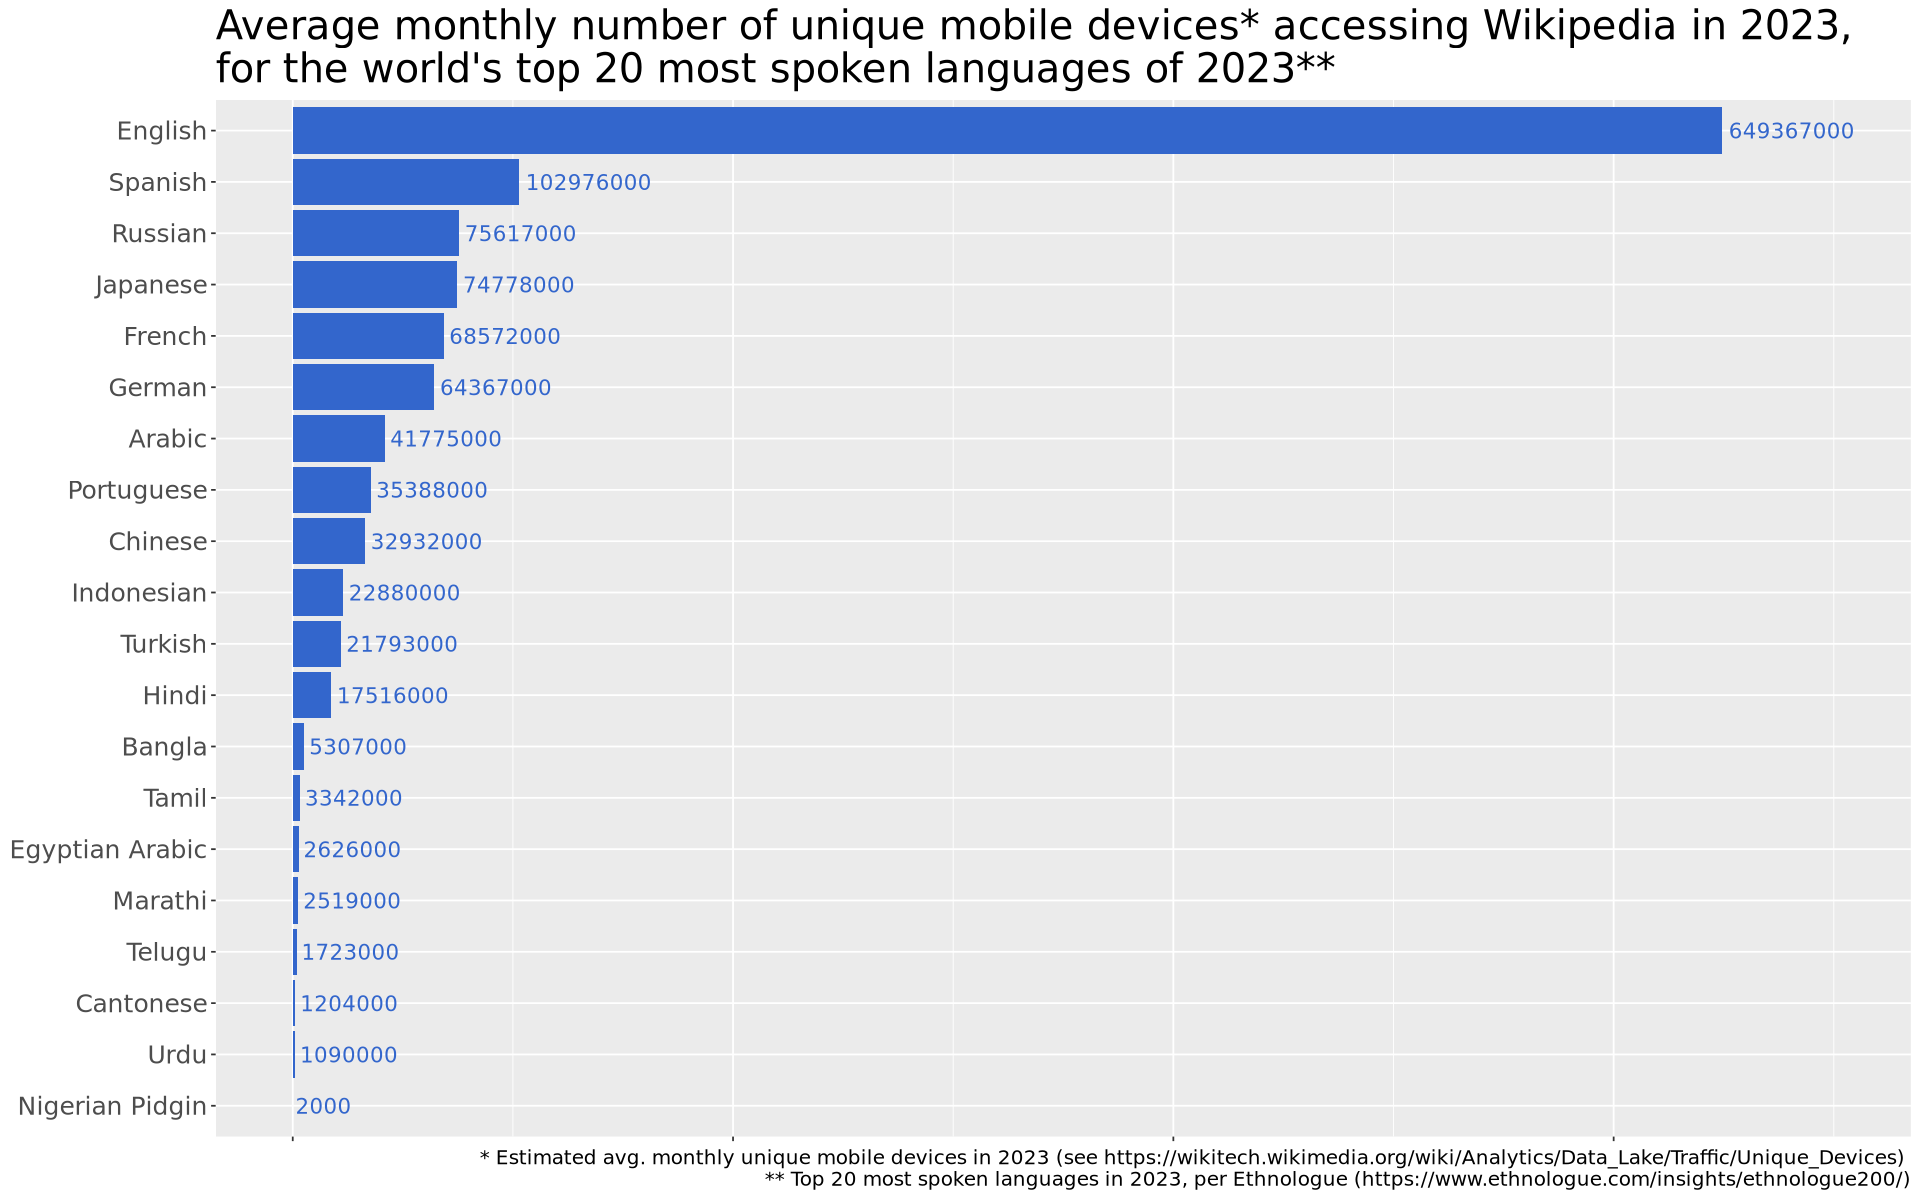

In [56]:
# Plot: Wikipedia mobile devices per language
options(repr.plot.width=16, repr.plot.height=10)
df_top_20 %>%
  ggplot(aes(x=reorder(language_name, wp_uniques_mobile), y=wp_uniques_mobile)) +
  geom_bar(position = position_dodge(), stat="identity", fill = "#3366CC") +
  geom_text(aes(label = round(wp_uniques_mobile,0)), hjust = -0.05, color="#3366CC", size=4.5) +
  theme_sol() +
  coord_flip() + 
  labs(title = "Average monthly number of unique mobile devices* accessing Wikipedia in 2023, \nfor the world's top 20 most spoken languages of 2023**",
    #   subtitle = "",
       caption = "* Estimated avg. monthly unique mobile devices in 2023 (see https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Unique_Devices) \n** Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  theme(axis.text.y = element_text(size=15), plot.subtitle = element_text(color="grey")) +
  ylim(c(0,700000000))

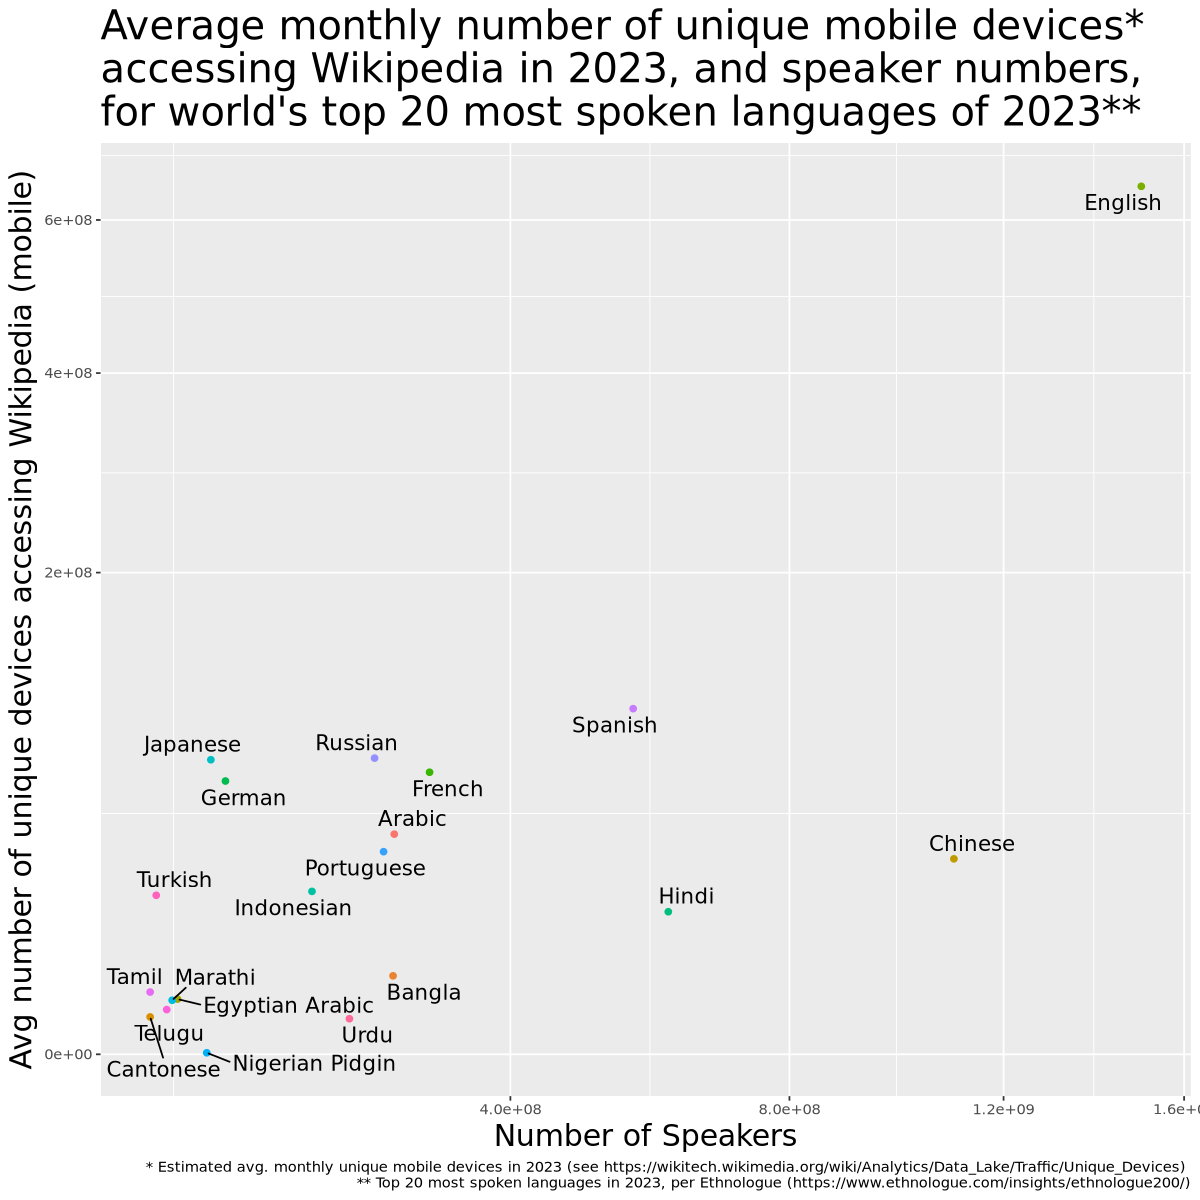

In [55]:
# Plot: Wikipiedia mobile unique devices x speaker numbers, per language
# Axis transformation: squareroot
options(repr.plot.width=10, repr.plot.height=10)
df_top_20 %>%
  ggplot(aes(x=speakers, y=wp_uniques_mobile, label=language_name)) +
  geom_point(aes(color=factor(language_name)) ) +
  geom_text_repel(size=4.5, max.overlaps=20) +
  theme(legend.position="none", axis.title=element_text(size=18), plot.title=element_text(size=24),
       plot.subtitle = element_text(color="grey", size=18)) +
  labs(title = "Average monthly number of unique mobile devices* \naccessing Wikipedia in 2023, and speaker numbers, \nfor world's top 20 most spoken languages of 2023**",
   #    subtitle = "",
       caption = "* Estimated avg. monthly unique mobile devices in 2023 (see https://wikitech.wikimedia.org/wiki/Analytics/Data_Lake/Traffic/Unique_Devices) \n** Top 20 most spoken languages in 2023, per Ethnologue (https://www.ethnologue.com/insights/ethnologue200/)")+
  xlab("Number of Speakers") + ylab("Avg number of unique devices accessing Wikipedia (mobile)") +
  scale_x_continuous(trans='sqrt') +
  scale_y_continuous(trans='sqrt')